# Import Libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joypy
from joypy import joyplot
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Define paths

In [2]:
data_path = os.path.dirname(os.getcwd()) + '/data'
figure_path = os.path.dirname(os.getcwd()) + '/figures'

In [3]:
PROT = pd.read_csv(data_path + '/predictions/human_proteome.csv')
AF = pd.read_csv(data_path + '/alphafold/alphafold_molpatch.csv', sep=',', engine='python') # Molpatch output on AlphaFold
AF_conf = pd.read_csv(data_path + '/alphafold/alphafold_confidence.csv', sep=',', engine='python')
consensus = pd.read_csv(data_path + '/expression/rna_tissue_consensus.tsv', sep='\t', engine='python') 

# Merging and preprocessing

### Expression data

In [4]:
TPM = consensus.sort_values('nTPM').drop_duplicates(subset=['Gene'], keep='last') 
TPM['TPM_LOG2'] = np.log2(TPM['nTPM']+1) # log tansform expression values

mapped = pd.read_csv(data_path + '/expression/Consensus_mapped.txt', sep='\t', engine='python') 
mapped['id'] = mapped['To']
mapped['Gene name'] = mapped['From']
mapped = mapped[['Gene name', 'id']]

TPM = TPM.merge(mapped, on='Gene name')
TPM['ID'] = TPM['id']
PROT = PROT.merge(TPM, on='ID')
PROT['LHP_PP_LOG2'] = np.log2(PROT['LHP_predicted']+1) # log tansform values

### AlphaFold data

In [5]:
AF['ID'] = AF['id']
analyse_patches = pd.merge(PROT, AF, on='ID', how='inner')
analyse_patches = analyse_patches[analyse_patches['LHP'] > 0]
analyse_patches = analyse_patches[analyse_patches['LHP_predicted'] > 0]
analyse_patches['LHP_AF_LOG2'] = np.log2(analyse_patches['LHP']+1) # log tansform values

AF_conf['ID'] = AF_conf['protein_id'] # get AlphaFold confidence scores
analyse_patches = pd.merge(analyse_patches, AF_conf, on='ID', how='inner')

analyse_patches['LHP_diff'] = analyse_patches['LHP_predicted'] - analyse_patches['LHP'] # calculate differences in LHP values

### Correlation between AlphaFold confidence and differences in LHP values 

In [6]:
from scipy.stats import pearsonr
print('correlation between alphafold confidence scores and LHP value differences')
print(pearsonr(analyse_patches['LHP_diff'], analyse_patches['avg_confidence']))

correlation between alphafold confidence scores and LHP value differences
(-0.038508627769284105, 9.925492476340119e-08)


### Correlation between alphafold and PatchProt

In [7]:
from scipy.stats import pearsonr
print('correlation between alphafold and PatchProt')
print(pearsonr(analyse_patches['LHP_predicted'], analyse_patches['LHP']))

correlation between alphafold and PatchProt
(0.8083199352318002, 0.0)


### Correlation between expression and PatchProt LHP values

In [8]:
from scipy.stats import pearsonr
print('correlation between expression and PatchProt')
print(pearsonr(analyse_patches['LHP_PP_LOG2'], analyse_patches['TPM_LOG2']))

correlation between expression and PatchProt
(-0.18629732646693098, 5.706815350542572e-149)


# Plot the relationship

In [9]:
analyse_patches

,ID,Fasta_sequence,SS3_predicted,SS8_predicted,TASA_predicted,THSA_predicted,RHSA_predicted,LHP_predicted,Species,Expression,...,LHP_PP_LOG2,Unnamed: 0,id_y,LHP,LHP_AF_LOG2,protein_id,f_value,model,avg_confidence,LHP_diff
0,Q8N7X0,MASKQTKKKEVHRINSAHGSDKSKDFYPFGSNVQSGSTEQKKGKFP...,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC...,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC...,61259.016,14557.4360,0.237637,2665.97000,HOMO SAPIENS,30%,...,11.380986,263,Q8N7X0,3546,11.792384,Q8N7X0,F1,model_v4,66.817469,-880.03000
1,Q5T1N1,MDEADFSEHTTYKQEDLPYDGDLSQIKIGNDYSFTSKKDGLEVLNQ...,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC...,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC...,21964.795,4745.6304,0.216056,504.18243,HOMO SAPIENS,60%,...,8.980661,4119,Q5T1N1,1314,10.360847,Q5T1N1,F1,model_v4,49.278684,-809.81757
2,Q92667,MAIQFRSLFPLALPGMLALLGWWWFFSRKKGHVSSHDEQQVEAGAV...,CCCCCCCCCCHHCCCHHHHHCCCCCCCCCCCCCCCCCCCCCCCCCC...,CCCCCGCCCCHCCCCHHHHHCCCCCCCCCCCCCCCCCCCCCCCCCC...,22804.264,6093.4736,0.267208,1787.24430,HOMO SAPIENS,10%,...,10.804328,8748,Q92667,2380,11.217352,Q92667,F1,model_v4,55.993876,-592.75570
3,Q5VUY0,MWDLALIFLAAACVFSLGVTLWVICSHFFTVHIPAAVGHPVKLRVL...,CCCHHHHHHHHHHHHHHHHHHHHHHHCCCCCCCCCCCCCCHHHHHH...,CCCHHHHHHHHHHHHHHHHHHHHHHCCTCCCCCCCGCCCHHHHHHH...,17742.473,5463.6533,0.307942,2257.24070,HOMO SAPIENS,40%,...,11.140984,16290,Q5VUY0,3857,11.913637,Q5VUY0,F1,model_v4,94.818108,-1599.75930
4,P62736,MCEEEDSTALVCDNGSGLCKAGFAGDDAPRAVFPSIVGRPRHQGVM...,CCCCCCCCCEEEEECCCCEEEEECCCCCCCEEEEEEEEECCCCCCC...,CCCCCCCCCEEEEECTSEEEEEECSSSSCCEEEEEEEEECCTCCCC...,16633.203,3970.8860,0.238732,1023.97720,HOMO SAPIENS,0%,...,10.001376,3692,P62736,1329,10.377211,P62736,F1,model_v4,95.327613,-305.02280
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19127,Q5JQC4,MSATGDRHPTQGDQEAPVSQEGAQAEAAGAGNQEGGDSGPDSSDVV...,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC...,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC...,9420.861,3225.0240,0.342328,1719.44140,HOMO SAPIENS,0%,...,10.748563,5534,Q5JQC4,2115,11.047124,Q5JQC4,F1,model_v4,52.769861,-395.55860
19128,Q5JQC4,MSATGDRHPTQGDQEAPVSQEGAQAEAAGAGNQEGGDSGPDSSDVV...,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC...,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC...,9420.861,3225.0240,0.342328,1719.44140,HOMO SAPIENS,0%,...,10.748563,5534,Q5JQC4,2115,11.047124,Q5JQC4,F1,model_v4,52.769861,-395.55860
19129,Q5JQC4,MSATGDRHPTQGDQEAPVSQEGAQAEAAGAGNQEGGDSGPDSSDVV...,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC...,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC...,9420.861,3225.0240,0.342328,1719.44140,HOMO SAPIENS,0%,...,10.748563,5534,Q5JQC4,2115,11.047124,Q5JQC4,F1,model_v4,52.769861,-395.55860
19130,Q5JQC4,MSATGDRHPTQGDQEAPVSQEGAQAEAAGAGNQEGGDSGPDSSDVV...,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC...,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC...,9420.861,3225.0240,0.342328,1719.44140,HOMO SAPIENS,0%,...,10.748563,5534,Q5JQC4,2115,11.047124,Q5JQC4,F1,model_v4,52.769861,-395.55860


In [17]:
first_distribution = analyse_patches[analyse_patches['LHP_diff'] < 0]
second_distribution = analyse_patches[analyse_patches['LHP_diff'] > 0]
print('mean confidence AlphaFold (first)', np.median(first_distribution['avg_confidence']))
print('mean confidence AlphaFold (second)', np.median(second_distribution['avg_confidence']))
print('mean expression AlphaFold (first)', np.median(first_distribution['TPM_LOG2']))
print('mean expression AlphaFold (second)', np.median(second_distribution['TPM_LOG2']))
second_distribution

mean confidence AlphaFold (first) 78.43294698655751
mean confidence AlphaFold (second) 76.70265400483711
mean expression AlphaFold (first) 5.55918505459995
mean expression AlphaFold (second) 5.4950555283680185


,ID,Fasta_sequence,SS3_predicted,SS8_predicted,TASA_predicted,THSA_predicted,RHSA_predicted,LHP_predicted,Species,Expression,...,LHP_PP_LOG2,Unnamed: 0,id_y,LHP,LHP_AF_LOG2,protein_id,f_value,model,avg_confidence,LHP_diff
7,P49703,MGNHLTEMAPTASSFLPHFQALHVVVIGLDSAGKTSLLYRLKFKEF...,CCCCCCCCCCCCCCCCCCCCEEEEEEEECCCCCHHHHHHHHHCCCC...,CCCCCCCCCCCCCCCCCCCCEEEEEEEECTTCCHHHHHHHHHTTCC...,9168.500,2268.3960,0.247412,776.8579,HOMO SAPIENS,0%,...,9.603363,6317,P49703,428,8.744834,P49703,F1,model_v4,89.893532,348.8579
8,Q5TGY3,MRVKPQGLVVTSSAVCSSPDYLREPKYYPGGPPTPRPLLPTRPPAS...,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC...,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC...,35669.242,11597.2480,0.325133,3984.8730,HOMO SAPIENS,60%,...,11.960680,9699,Q5TGY3,2155,11.074141,Q5TGY3,F1,model_v4,38.655870,1829.8730
14,Q8WXK4,MNLMDITKIFSLLQPDKEEEDTDTEEKQALNQAVYDNDSYTLDQLL...,CCCCCCCCCCCCCCCCCCCCCCCCHHHHHHHHHHHCCCHHHHHHHH...,CCCCCCCCCCCCCCCCCCCCCCCCHHHHHHHHHHHTTCHHHHHHHH...,14249.218,3852.3843,0.270358,1351.5156,HOMO SAPIENS,10%,...,10.401430,10191,Q8WXK4,1311,10.357552,Q8WXK4,F1,model_v4,83.328770,40.5156
16,Q99700,MRSAAAAPRSPAVATESRRFAAARWPGWRSLQRPARRSGRGGGGAA...,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC...,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC...,39381.470,11354.1080,0.288311,3714.2893,HOMO SAPIENS,60%,...,11.859259,10273,Q99700,2698,11.398209,Q99700,F1,model_v4,46.081325,1016.2893
17,O75882,MVAAAAATEARLRRRTAATAALAGRSGGPHWDWDVTRAGRPGLGAG...,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC...,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC...,61776.730,15600.2100,0.252526,4882.6590,HOMO SAPIENS,90%,...,12.253747,1322,O75882,2506,11.291746,O75882,F1,model_v4,79.125661,2376.6590
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19098,Q7Z572,MDNRNTQMYTEEEKTVNPFLPSTPGPKKAKGGGEAVETHPAPGPLP...,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC...,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC...,17038.080,4702.3920,0.275993,1410.1792,HOMO SAPIENS,60%,...,10.462685,10377,Q7Z572,1300,10.345405,Q7Z572,F1,model_v4,59.515906,110.1792
19100,Q9H2D6,MEEVPGDALCEHFEANILTQNRCQNCFHPEEAHGARYQELRSPSGA...,CCCCCCCCCCCCCHCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC...,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC...,67146.140,18848.7970,0.280713,6531.9620,HOMO SAPIENS,60%,...,12.673522,12263,Q9H2D6,1781,10.799282,Q9H2D6,F1,model_v4,39.821611,4750.9620
19103,A6NDE4,MVEADHPGKLFIGGLNRETNEKMLKAVFGKHGPISEVLLIKDRTSK...,CCCCCCCCEEEEECCCHCCCHHHHHHHHHCCCCCEEEEEEECCCCC...,CCCCCCCCEEEEECCCTTCCHHHHHHHHTTTSCCEEEEEEECTTSC...,12195.650,3308.3982,0.271277,1088.4902,HOMO SAPIENS,40%,...,10.089438,3985,A6NDE4,565,9.144658,A6NDE4,F1,model_v4,49.988286,523.4902
19118,Q08AF8,MEWKLEQSMREQALLKAQLTQLKESLKEVQLERDEYAEHLKGERAR...,HHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHH...,HHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHH...,18839.668,5477.8467,0.290761,2449.3499,HOMO SAPIENS,60%,...,11.258772,9638,Q08AF8,2286,11.159241,Q08AF8,F1,model_v4,65.485721,163.3499


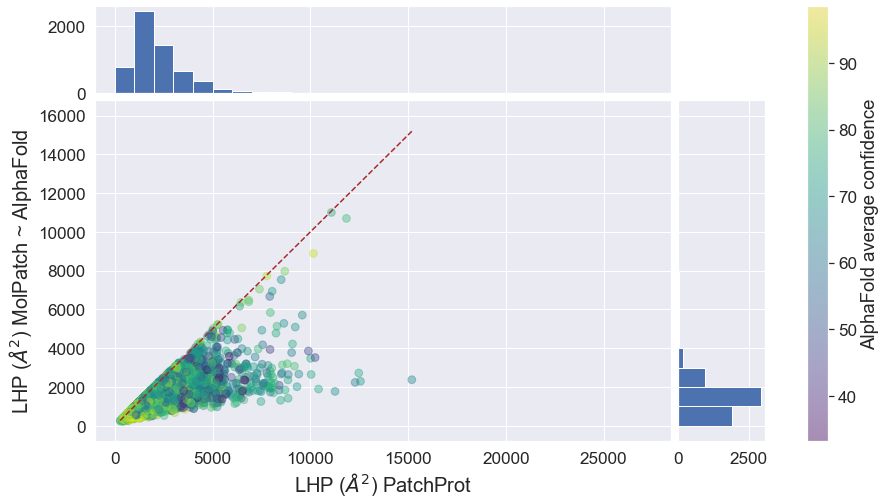

In [13]:
#analyse_patches = analyse_patches.sort_values(by=['avg_confidence'], ascending=False)
x = second_distribution['LHP_predicted']
y = second_distribution['LHP']
colors = second_distribution['avg_confidence']

# Set the style and font scale
sns.set_style('white')
sns.set(font_scale=1.55)
fig, ax = plt.subplots(figsize=(15, 8))

cm = plt.cm.get_cmap('viridis') # Scatter plot
im = ax.scatter(x, y, s=60, c=colors, alpha=0.4, cmap=cm)
fig.colorbar(im, ax=ax, label='AlphaFold average confidence')

# Plotting a diagonal line
ax.plot([min(x), max(x)], [min(x), max(x)], color='brown', linestyle='--')

ax.set_xlabel('LHP ($Å^2$) PatchProt', fontsize=20)
ax.set_ylabel('LHP ($Å^2$) MolPatch ~ AlphaFold', fontsize=20)
ax.set_title('', fontsize=30)

# Create divider for existing axes instance
divider = make_axes_locatable(ax)

# Create new axes for histograms
ax_histx = divider.append_axes("top", 1.2, pad=0.1, sharex=ax)
ax_histy = divider.append_axes("right", 1.2, pad=0.1, sharey=ax)

# Make some labels invisible
ax_histx.xaxis.set_tick_params(labelbottom=False)
ax_histy.yaxis.set_tick_params(labelleft=False)

binwidth = 1000  # Adjust this based on your data's range
xymax = max(np.max(np.abs(x)), np.max(np.abs(y)))
lim = (int(xymax/binwidth) + 1) * binwidth

bins = np.arange(0, lim + binwidth, binwidth)  # Adjusted to start from 0
ax_histx.hist(x, bins=bins)
ax_histy.hist(y, bins=bins, orientation='horizontal')

# # Set ticks for histograms
# ax_histx.set_yticks([0, 50, 100])  # Adjust as needed
# ax_histy.set_xticks([0, 50, 100])  # Adjust as needed
ax.set_xlim([-1000, 28450])

#fig.savefig(figure_path + '/patchprot_AlphaFold_w_conf.png', dpi = 600, bbox_inches='tight')
plt.show()

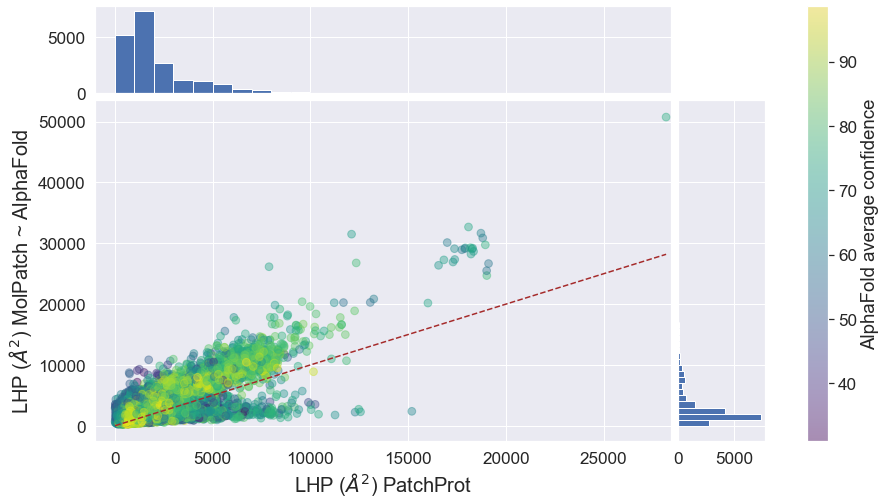

In [51]:
#analyse_patches = analyse_patches.sort_values(by=['avg_confidence'], ascending=False)
x = analyse_patches['LHP_predicted']
y = analyse_patches['LHP']
colors = analyse_patches['avg_confidence']

# Set the style and font scale
sns.set_style('white')
sns.set(font_scale=1.55)
fig, ax = plt.subplots(figsize=(15, 8))

cm = plt.cm.get_cmap('viridis') # Scatter plot
im = ax.scatter(x, y, s=60, c=colors, alpha=0.4, cmap=cm)
fig.colorbar(im, ax=ax, label='AlphaFold average confidence')

# Plotting a diagonal line
ax.plot([min(x), max(x)], [min(x), max(x)], color='brown', linestyle='--')

ax.set_xlabel('LHP ($Å^2$) PatchProt', fontsize=20)
ax.set_ylabel('LHP ($Å^2$) MolPatch ~ AlphaFold', fontsize=20)
ax.set_title('', fontsize=30)

# Create divider for existing axes instance
divider = make_axes_locatable(ax)

# Create new axes for histograms
ax_histx = divider.append_axes("top", 1.2, pad=0.1, sharex=ax)
ax_histy = divider.append_axes("right", 1.2, pad=0.1, sharey=ax)

# Make some labels invisible
ax_histx.xaxis.set_tick_params(labelbottom=False)
ax_histy.yaxis.set_tick_params(labelleft=False)

binwidth = 1000  # Adjust this based on your data's range
xymax = max(np.max(np.abs(x)), np.max(np.abs(y)))
lim = (int(xymax/binwidth) + 1) * binwidth

bins = np.arange(0, lim + binwidth, binwidth)  # Adjusted to start from 0
ax_histx.hist(x, bins=bins)
ax_histy.hist(y, bins=bins, orientation='horizontal')

# # Set ticks for histograms
# ax_histx.set_yticks([0, 50, 100])  # Adjust as needed
# ax_histy.set_xticks([0, 50, 100])  # Adjust as needed
ax.set_xlim([-1000, 28450])

fig.savefig(figure_path + '/patchprot_AlphaFold_w_conf.png', dpi = 600, bbox_inches='tight')
plt.show()

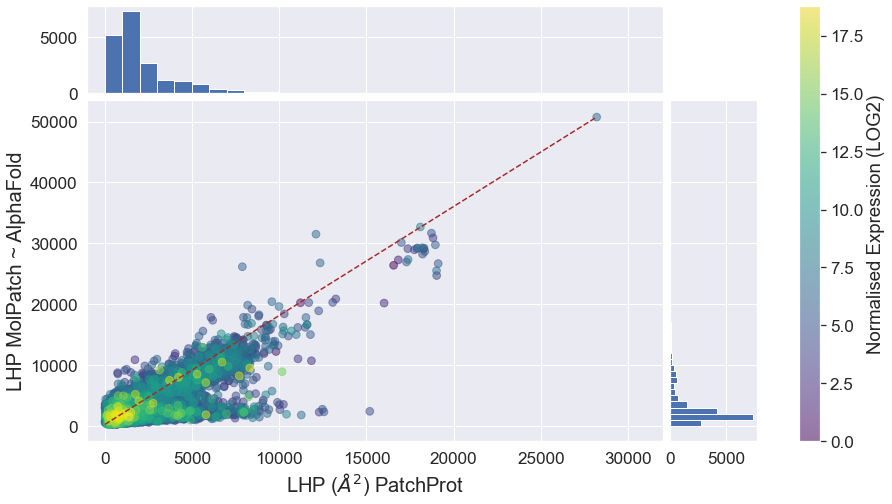

In [57]:
# Sort values and extract data
analyse_patches = analyse_patches.sort_values(by=['TPM_LOG2'], ascending=True)
x = analyse_patches['LHP_predicted']
y = analyse_patches['LHP']
colors = analyse_patches['TPM_LOG2']

# Set the style and font scale
sns.set_style('white')
sns.set(font_scale=1.55)

# Create the main figure and axes
fig, ax = plt.subplots(figsize=(15, 8))

# Scatter plot
cm = plt.cm.get_cmap('viridis')
im = ax.scatter(x, y, s=60, c=colors, alpha=0.5, cmap=cm)
fig.colorbar(im, ax=ax, label='Normalised Expression (LOG2)')

# Plotting a diagonal line
ax.plot([min(x), max(x)], [min(y), max(y)], color='brown', linestyle='--')

# Set labels and title
ax.set_xlabel('LHP ($Å^2$) PatchProt', fontsize=20)
ax.set_ylabel('LHP ($Å^2$) MolPatch ~ AlphaFold', fontsize=20)
ax.set_title('', fontsize=30)

# Create divider for existing axes instance
divider = make_axes_locatable(ax)

# Create new axes for histograms
ax_histx = divider.append_axes("top", 1.2, pad=0.1, sharex=ax)
ax_histy = divider.append_axes("right", 1.2, pad=0.1, sharey=ax)

# Make some labels invisible
ax_histx.xaxis.set_tick_params(labelbottom=False)
ax_histy.yaxis.set_tick_params(labelleft=False)

# Histograms
binwidth = 1000  # Adjust this based on your data's range
xymax = max(np.max(np.abs(x)), np.max(np.abs(y)))
lim = (int(xymax/binwidth) + 1) * binwidth

bins = np.arange(0, lim + binwidth, binwidth)  # Adjusted to start from 0
ax_histx.hist(x, bins=bins)
ax_histy.hist(y, bins=bins, orientation='horizontal')
ax.set_xlim([-1000, 32000])

fig.savefig(figure_path + '/patchprot_AlphaFold_w_expression.png', dpi = 300, bbox_inches='tight')
plt.show()

# Check outliers

In [17]:
analyse_patches = analyse_patches.sort_values(by=['LHP_diff'], ascending=True)
analyse_patches 

,ID,Fasta_sequence,SS3_predicted,SS8_predicted,TASA_predicted,THSA_predicted,RHSA_predicted,LHP_predicted,Species,Expression,...,LHP_PP_LOG2,Unnamed: 0,id_y,LHP,LHP_AF_LOG2,protein_id,f_value,model,avg_confidence,LHP_diff
8557,Q92508,MEPHVLGAVLYWLLLPCALLAACLLRFSGLSLVYLLFLLLLPWFPG...,CCHHHHHHHHHHHHHHHHHHHHHHHCCCHHHHHHHHHHHHHHCCCC...,CCHHHHHHHHHHHHHHHHHHHHHHTTCCHHHHHHHHHHHHHHTCCC...,114668.140,49781.973,0.434140,28188.7830,HOMO SAPIENS,0%,...,14.782885,11884,Q92508,50744,15.630978,Q92508,F1,model_v4,73.436136,-22555.2170
18819,Q9H330,MADGGGPKDAPSLRSSPGPAPRVPRAVGPSGGGGETPRTAALALRF...,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC...,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC...,41844.220,19923.717,0.476140,12107.3220,HOMO SAPIENS,0%,...,13.563711,20046,Q9H330,31496,14.942927,Q9H330,F1,model_v4,68.820774,-19388.6780
3465,Q14667,MPLFFSALLVLLLVALSALFLGRWLVVRLATKWCQRKLQAELKIGS...,CCCCHHHHHHHHHHHHCHHHHHHHHHHHHHHHHHHHHCCCEEEECE...,CCCCCCHHHHHHHHHHCHHHHHHHHHHHHHHHHHHHHTTCEEEEEE...,102981.190,26078.695,0.253237,7888.1733,HOMO SAPIENS,30%,...,12.945658,1598,Q14667,26147,14.674413,Q14667,F1,model_v4,70.705794,-18258.8267
11266,Q13698,MEPSSPQDEGLRKKQPKKPVPEILPRPPRALFCLTLENPLRKACIS...,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCHHHHHHHH...,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCTCHHHHHHHH...,92715.766,34502.890,0.372136,18085.8240,HOMO SAPIENS,40%,...,14.142651,16686,Q13698,32680,14.996165,Q13698,F1,model_v4,71.546380,-14594.1760
7865,O60337,MDTAEEDICRVCRSEGTPEKPLYHPCVCTGSIKFIHQECLVQWLKH...,CCCCCCCEEEECCCCCCCCCCCCCCCCCCCCCEEECHHHHHHHHHH...,CCCCCCCCCEECTCCCCTTCCCCCCCCCTTCCEEECHHHHHHHHHH...,41258.470,20500.020,0.496868,12345.9100,HOMO SAPIENS,0%,...,13.591862,1852,O60337,26774,14.708599,O60337,F1,model_v4,77.541780,-14428.0900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11416,Q13439,MFKKLKQKISEEQQQLQQALAPAQASSNSSTPTRMRSRTSSFTEQL...,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC...,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC...,123549.500,30518.533,0.247015,11263.9375,HOMO SAPIENS,30%,...,13.459552,10301,Q13439,1773,10.792790,Q13439,F1,model_v4,66.099812,9490.9375
1556,H7BZ55,MSSASSEPGNGDASQQPLLGLDTVIQRLEDTILSPTASREDRALTV...,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC...,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC...,89351.200,26837.078,0.300355,12475.4360,HOMO SAPIENS,60%,...,13.606918,15101,H7BZ55,2723,11.411511,H7BZ55,F1,model_v4,72.706273,9752.4360
18351,O15078,MPPNINWKEIMKVDPDDLPRQEELADNLLISLSKVEVNELKSEKQE...,CCCCCCHHHHCCCCCCCCCCHHHHHHHHHHHHHHCCHHHCCCCCHH...,CCCCCCHHHHCCCCTTCCHCHHHHHHHHHHHHHHHHHHHCCCCCHH...,140270.810,34981.620,0.249386,12288.9690,HOMO SAPIENS,90%,...,13.585194,5830,O15078,2238,11.128639,O15078,F1,model_v4,61.856777,10050.9690
16762,Q5TZA2,MSLGLARAQEVELTLETVIQTLESSVLCQEKGLGARDLAQDAQITS...,CCCCCCCCCCCCCCHHHHHHHHHHHHHHCCCCCCCCCCCCCCCCCC...,CCCCCCCCCCCCCCHHHHHHHHHHHHHHHHHCCCCCCCCCCCCCCC...,99593.830,28215.234,0.283303,12565.0910,HOMO SAPIENS,50%,...,13.617248,8994,Q5TZA2,2293,11.163650,Q5TZA2,F1,model_v4,69.317784,10272.0910


In [18]:
good_prediction = analyse_patches[analyse_patches['LHP_diff'] > 0]
good_prediction

,ID,Fasta_sequence,SS3_predicted,SS8_predicted,TASA_predicted,THSA_predicted,RHSA_predicted,LHP_predicted,Species,Expression,...,LHP_PP_LOG2,Unnamed: 0,id_y,LHP,LHP_AF_LOG2,protein_id,f_value,model,avg_confidence,LHP_diff
3141,Q9BYR0,MVSSCCGSVCSDQGCSQDLCQETCCRPSCCQTTCCRTTCYRPSCCV...,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCEEEEEEEECCCCCC...,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCEEEEEEEECCCCCC...,10396.496,3960.9663,0.380991,2245.2415,HOMO SAPIENS,0%,...,11.133297,13478,Q9BYR0,2245,11.133142,Q9BYR0,F1,model_v4,35.717048,0.2415
12802,Q9NR80,MPWEEPAGEKPSCSHSQKAFHMEPAQKPCFTTDMVTWALLCISAET...,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC...,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC...,23190.814,5523.1855,0.238163,1255.4922,HOMO SAPIENS,10%,...,10.295186,14138,Q9NR80,1255,10.294621,Q9NR80,F1,model_v4,69.910435,0.4922
8060,Q9NQR4,MTSFRLALIQLQISSIKSDNVTRACSFIREAATQGAKIVSLPECFN...,CCCEEEEEEECCCCCCHHHHHHHHHHHHHHHHHCCCCEEEECCCCC...,CCCEEEEEEECCCCSCHHHHHHHHHHHHHHHHHTTCSEEEECCTCC...,12156.670,2981.8127,0.245282,927.5315,HOMO SAPIENS,0%,...,9.858807,6980,Q9NQR4,927,9.857981,Q9NQR4,F1,model_v4,97.727500,0.5315
10662,P49591,MVLDLDLFRVDKGGDPALIRETQEKRFKDPGLVDQLVKADSEWRRC...,CCCCHHHHHHHCCCCHHHHHHHHHHHHCCHCHHHHHHHHHHHHHHH...,CCCCHHHHHHHHTCCHHHHHHHHHHHHTCTTHHHHHHHHHHHHHHH...,23842.340,5536.3130,0.232205,1428.5583,HOMO SAPIENS,0%,...,10.481354,20055,P49591,1428,10.480790,P49591,F1,model_v4,93.248560,0.5583
14452,P01374,MTPPERLFLPRVCGTTLHLLLLGLLLVLLPGAQGLPGVGLTPSAAQ...,CCCCCCCCCCCCCCCCCCCHCHCCCCCCCCCCCCCCCCCCCCCHHH...,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCHHC...,9558.623,3078.2312,0.322037,1440.8254,HOMO SAPIENS,0%,...,10.493681,11896,P01374,1440,10.492855,P01374,F1,model_v4,83.557610,0.8254
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11416,Q13439,MFKKLKQKISEEQQQLQQALAPAQASSNSSTPTRMRSRTSSFTEQL...,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC...,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC...,123549.500,30518.5330,0.247015,11263.9375,HOMO SAPIENS,30%,...,13.459552,10301,Q13439,1773,10.792790,Q13439,F1,model_v4,66.099812,9490.9375
1556,H7BZ55,MSSASSEPGNGDASQQPLLGLDTVIQRLEDTILSPTASREDRALTV...,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC...,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC...,89351.200,26837.0780,0.300355,12475.4360,HOMO SAPIENS,60%,...,13.606918,15101,H7BZ55,2723,11.411511,H7BZ55,F1,model_v4,72.706273,9752.4360
18351,O15078,MPPNINWKEIMKVDPDDLPRQEELADNLLISLSKVEVNELKSEKQE...,CCCCCCHHHHCCCCCCCCCCHHHHHHHHHHHHHHCCHHHCCCCCHH...,CCCCCCHHHHCCCCTTCCHCHHHHHHHHHHHHHHHHHHHCCCCCHH...,140270.810,34981.6200,0.249386,12288.9690,HOMO SAPIENS,90%,...,13.585194,5830,O15078,2238,11.128639,O15078,F1,model_v4,61.856777,10050.9690
16762,Q5TZA2,MSLGLARAQEVELTLETVIQTLESSVLCQEKGLGARDLAQDAQITS...,CCCCCCCCCCCCCCHHHHHHHHHHHHHHCCCCCCCCCCCCCCCCCC...,CCCCCCCCCCCCCCHHHHHHHHHHHHHHHHHCCCCCCCCCCCCCCC...,99593.830,28215.2340,0.283303,12565.0910,HOMO SAPIENS,50%,...,13.617248,8994,Q5TZA2,2293,11.163650,Q5TZA2,F1,model_v4,69.317784,10272.0910


# Analyse expression separately 

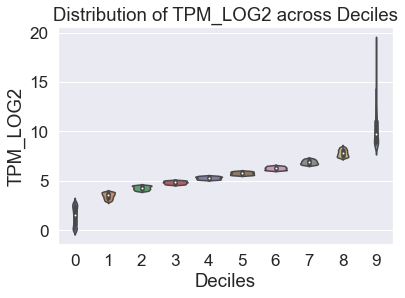

In [19]:
analyse_patches = analyse_patches.sort_values(by=['TPM_LOG2'], ascending=True)
analyse_patches['nxp_deciles'] = pd.qcut(analyse_patches['TPM_LOG2'], q=10, labels=False)

sns.violinplot(x='nxp_deciles', y='TPM_LOG2', data=analyse_patches)
plt.xlabel('Deciles')
plt.ylabel('TPM_LOG2')
plt.title('Distribution of TPM_LOG2 across Deciles')
plt.show()

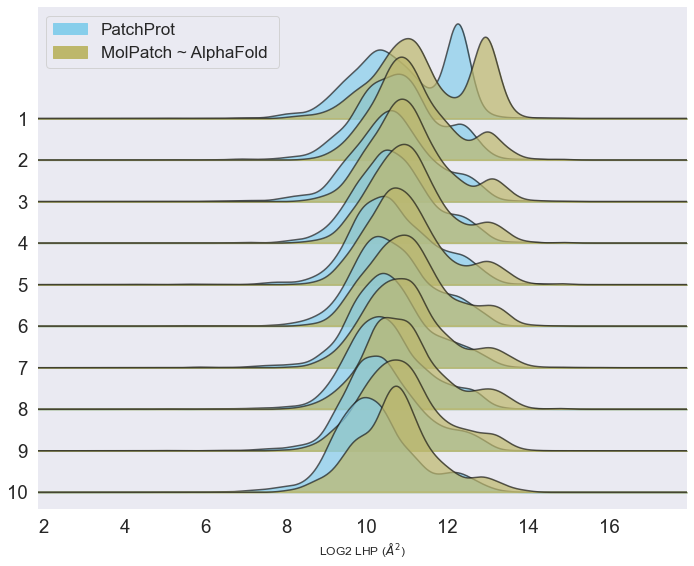

In [86]:
df = analyse_patches[['nxp_deciles', 'LHP_PP_LOG2', 'LHP_AF_LOG2']]

new_df = pd.DataFrame({
    'var1': df['LHP_PP_LOG2'],
    'var2': df['LHP_AF_LOG2'],
    'group': df['nxp_deciles'] + 1
})

colors = ['skyblue', 'darkkhaki']
fig, ax = joypy.joyplot(new_df, by="group", figsize=(10, 8), alpha=0.7, color=colors)

import matplotlib.patches as mpatches 
legend_patches = [
    mpatches.Patch(color='skyblue', label='PatchProt'),
    mpatches.Patch(color='darkkhaki', label='MolPatch ~ AlphaFold ')
]

plt.legend(handles=legend_patches, loc='upper left')

plt.xlabel('LOG2 LHP ($Å^2$)', fontsize=12)
plt.ylabel('', fontsize=12)
plt.title('', fontsize=14)
fig.savefig(figure_path + '/expression.png', dpi=600, bbox_inches='tight')
plt.show()

# Stats 

In [80]:
from scipy.stats import mannwhitneyu

decile1 = analyse_patches[analyse_patches['nxp_deciles'] == 0]
decile10 = analyse_patches[analyse_patches['nxp_deciles'] == 9]

decile1_values = decile1['LHP_predicted'] 
decile10_values = decile10['LHP_predicted'] 

# Perform the Mann-Whitney U test
statistic, p_value = mannwhitneyu(decile1_values, decile10_values)

# Output the results
print("Mann-Whitney U statistic:", statistic)
print("p-value:", p_value)

Mann-Whitney U statistic: 2515141.5
p-value: 1.3080534533387538e-84


In [87]:
decile1 = analyse_patches[analyse_patches['nxp_deciles'] == 0]
decile10 = analyse_patches[analyse_patches['nxp_deciles'] == 9]

decile1_values = decile1['LHP_PP_LOG2'] 
decile10_values = decile10['LHP_PP_LOG2'] 

# Perform the Mann-Whitney U test
statistic, p_value = mannwhitneyu(decile1_values, decile10_values)

# Output the results
print("Mann-Whitney U statistic:", statistic)
print("p-value:", p_value)

Mann-Whitney U statistic: 2515141.5
p-value: 1.3080534533387538e-84


In [89]:
decile1_values = decile1['LHP_AF_LOG2'] 
decile10_values = decile10['LHP_AF_LOG2'] 

# Perform the Mann-Whitney U test
statistic, p_value = mannwhitneyu(decile1_values, decile10_values)

# Output the results
print("Mann-Whitney U statistic:", statistic)
print("p-value:", p_value)

Mann-Whitney U statistic: 2477610.0
p-value: 1.331239354216961e-75


In [91]:
decile1_values = decile1['LHP'] 
decile10_values = decile10['LHP'] 

# Perform the Mann-Whitney U test
statistic, p_value = mannwhitneyu(decile1_values, decile10_values)

# Output the results
print("Mann-Whitney U statistic:", statistic)
print("p-value:", p_value)

Mann-Whitney U statistic: 2477610.0
p-value: 1.331239354216961e-75


In [84]:
# # Set the figure size and font scale
# fig, ax = plt.subplots(figsize=(10, 8))
# sns.set(font_scale=1.55)

# # Plot the split violins
# sns.violinplot(data=analyse_patches, x='nxp_deciles', y='LHP_AF_LOG2', ax=ax, color='skyblue', alpha=0.7, label='LHP_AF_LOG2', split=True)
# sns.violinplot(data=analyse_patches, x='nxp_deciles', y='LHP_PP_LOG2', ax=ax, color='salmon', alpha=0.7, label='LHP_PP_LOG2', split=True)

# # Set labels and title
# ax.set_xlabel('Deciles', fontsize=20)
# ax.set_ylabel('LOG2', fontsize=20)
# ax.set_title('', fontsize=30)

# plt.show()